In [1]:
from helper import print_frame
from moviepy.editor import *
from decord import VideoReader
from decord import cpu, gpu
import cv2
from tqdm import tqdm
import numpy as np
import os

VID_DIR = os.path.join('Media', 'Videos')
VID_FILES = [os.path.join(VID_DIR, f) for f in os.listdir(VID_DIR) if f.split('.')[-1].lower() in ['mp4', 'avi', 'mkv']]
print(f'{len(VID_FILES)} videos found.', [f.split('\\')[-1] for f in VID_FILES])

# Audio to split clips from
AUD_DIR = os.path.join('Media', 'Audio')
AUD_FILE = os.path.join(AUD_DIR, 'drums.wav')
print(AUD_FILE)

# Audio to stitch to final video
FINAL_AUDIO = os.path.join(AUD_DIR, 'Greydon Square - Society Versus Nature.wav')

EXPORT_FILENAME = 'music_video.mp4'

3 videos found. ['Human Planet Disc 1_t00.mkv', 'Human Planet Disc 1_t01.mkv', 'Human Planet Disc 1_t02.mkv']
Media\Audio\drums.wav


### Pseudo Logic:
    video_list = []
    for split_time in split_times:
        clip = next(clips)
    
        while len(clip) < split_len:
            clip = next(clips)
        
        video_list += [clip[:split_len]]
       
    clip_list2vid(video_list)

### TODO:
- Create tool to find best audio split points
- Clean up print_frame debug in functions once no longer being used
- Add progress bar to audio read data input
- Yield clips instead of processing all for each video

### Ideas:
- Change frame changed threshold with variation in audio amplitude?

### Potentionally Useful Functions
- clip.get_frame(time)
- clip.ipython_display(width=240)

In [2]:
import time

In [3]:
# video = VideoFileClip(VID_FILES[0])

In [4]:
# print('Frames/Second:', video.reader.fps)
# print('Frame Count:', video.reader.nframes)
# print('Video Length:', video.duration)

In [5]:
# print_frame(video.get_frame(np.random.randint(0, video.duration)))

# Split Video In To Clips

In [6]:
def scene_changed(prev_frame, frame, delta_thresh=30):
    delta = abs(np.mean(prev_frame) - np.mean(frame))
    
    if delta > delta_thresh:
        return True
    return False

# def split_video(video, max_clips=0, check_freq = 1, print_split_frames=False, print_cmp_frames=False):
#     """
#     print_split_frames - for troubleshooting, may remove later
#     print_cmp_frames - for troubleshooting, may remove later
#     max_clips - set above 0 to stop early when len(clips) greater than max_clips
#     check_freq [seconds] - how often to compare two frames for scene change
#     """
#     clip_cnt = 0      # Number of clips created from video
#     start_time = 0    # time in seconds from video where current clip starts
#     clips = []        # list of subclips of video file created by video split
    
#     frame_freq = int(video.reader.fps*check_freq)
#     print(f'Compare frames every {check_freq} seconds. This equals {frame_freq} frames.')

#     prev_frame = video.get_frame(0) # Initialize previous frame
    
#     for i, (time, frame) in tqdm(enumerate(video.iter_frames(with_times=True))):

#         if i % frame_freq == 0:
#             if print_cmp_frames:
#                 print_frame(np.append(prev_frame, frame, axis=1))

#             if i > 0: # Skip first frame
#                 if start_time != stop_time and scene_changed(prev_frame, frame, delta_thresh=20):
#                     if print_split_frames:
#                         print_frame(prev_frame)

#                     clips += [video.subclip(start_time, stop_time)]

#                     start_time = time

#                     clip_cnt += 1

#             prev_frame = frame.copy()
#             stop_time = time

#             # Exit when we have the number of clips requested
#             if max_clips != 0 and clip_cnt > max_clips:
#                 break
#     return clips

In [7]:
# def split_video2(vid_filename, check_freq=1, print_split_frames=False, print_cmp_frames=False):
#     """
#     print_split_frames - for troubleshooting, may remove later
#     print_cmp_frames - for troubleshooting, may remove later
#     max_clips - set above 0 to stop early when len(clips) greater than max_clips
#     check_freq [seconds] - how often to compare two frames for scene change
#     """
#     video = VideoFileClip(vid_filename)
#     cap = cv2.VideoCapture(vid_filename) # Uses opencv to iterate frames because it's faster

#     clip_cnt = 0  # Number of clips created from video
#     start_time = 0  # time in seconds from video where current clip starts
#     clips = []  # list of subclips of video file created by video split

#     frame_freq = int(video.reader.fps * check_freq)
#     print(f'Compare frames every {check_freq} seconds. This equals {frame_freq} frames.')

#     total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

#     cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
#     _, prev_frame = cap.read()  # Initialize previous frame

#     for i in range(0, total_frames, frame_freq):
#         cap.set(cv2.CAP_PROP_POS_FRAMES, i)
#         _, frame = cap.read()

#         if print_cmp_frames:
#             print_frame(np.append(prev_frame, frame, axis=1))

#         if i > 0:  # Skip first frame
#             if start_time != stop_time and scene_changed(prev_frame, frame, delta_thresh=20):
#                 if print_split_frames:
#                     print_frame(prev_frame)

#                 clip = video.subclip(start_time, stop_time)

#                 start_time = i / video.reader.fps

#                 clip_cnt += 1
                
#                 yield clip

#         prev_frame = frame.copy()
#         stop_time = i / video.reader.fps      

In [21]:
def split_video3(vid_filename, check_freq=1, print_split_frames=False, print_cmp_frames=False):
    """
    print_split_frames - for troubleshooting, may remove later
    print_cmp_frames - for troubleshooting, may remove later
    max_clips - set above 0 to stop early when len(clips) greater than max_clips
    check_freq [seconds] - how often to compare two frames for scene change
    """
    with open(vid_filename, 'rb') as f:
        video = VideoFileClip(vid_filename)
        vr = VideoReader(vid_filename, ctx=cpu(0))

        clip_cnt = 0  # Number of clips created from video
        start_time = 0  # time in seconds from video where current clip starts
        clips = []  # list of subclips of video file created by video split

        frame_freq = int(video.reader.fps * check_freq)
        print(f'Compare frames every {check_freq} seconds. This equals {frame_freq} frames.')

        total_frames = len(vr)
        
        prev_frame = vr[0]

        for i in range(0, total_frames, frame_freq):
            frame = vr[i].asnumpy()

            if print_cmp_frames:
                print_frame(np.append(prev_frame, frame, axis=1))

            if i > 0:  # Skip first frame
                if start_time != stop_time and scene_changed(prev_frame, frame, delta_thresh=20):
                    if print_split_frames:
                        print_frame(prev_frame)

                    clip = video.subclip(start_time, stop_time)

                    start_time = i / video.reader.fps

                    clip_cnt += 1

                    yield clip

            prev_frame = frame
            stop_time = i / video.reader.fps

# Audio

In [9]:
import wave
import pyaudio
import matplotlib.pyplot as plt

In [10]:
def open_stream(audio_file, CHUNK_MUL=1):
    CHUNK = 1024*CHUNK_MUL
    
    wf = wave.open(audio_file, 'rb')
    RATE = wf.getframerate()
    FPS = RATE / CHUNK

    p = pyaudio.PyAudio()

    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=RATE,
                    output=True)
    
    return stream, wf, CHUNK, RATE

def get_audio_data():
    stream, wf, CHUNK, RATE = open_stream(AUD_FILE) 
    
    cnt = 0
    while True:
        # Read next frame
        data = wf.readframes(CHUNK)
        if len(data) < CHUNK:
            break

        data_int = np.frombuffer(data, dtype=np.int32) # Read bytes to int
        data_int = np.resize(data_int, (1, CHUNK)) # Handle final CHUNK where size might be less than CHUNK size

        if cnt == 0:
            all_data = data_int.copy()
        else:
            all_data = np.append(all_data, data_int, axis=0)
        
        cnt += 1  
    
    return all_data, CHUNK, RATE

In [11]:
audio_data, CHUNK, RATE = get_audio_data()
#audio_data = [v for chunk in audio_data for v in chunk] # Flatten

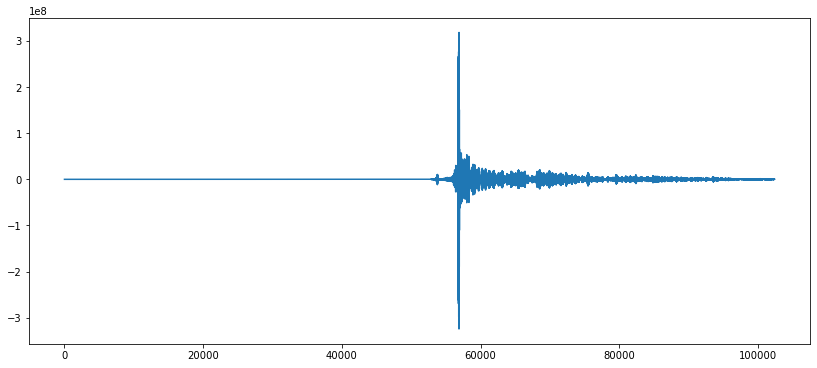

In [12]:
plt.figure(figsize=(14,6))
plt.plot([v for chunk in audio_data[:100] for v in chunk])
plt.show()

In [13]:
def moving_average(x, width=10):
    return np.convolve(x, np.ones(width), 'valid') / width

In [14]:
def is_increasing(data):
    data = moving_average(data, width=400)
#     pct_increasing = sum([1 for i in range(1, len(data)) if data[i] > data[i-1]])/len(data)
#     return pct_increasing > 0.5
    return np.mean(np.diff(data, n=2)) > 0

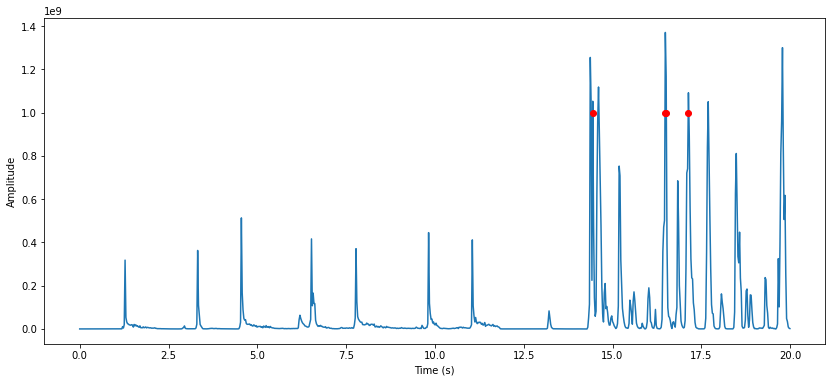

In [15]:
max_data = [np.max(r) for r in audio_data]
seconds = [(CHUNK / RATE)*i for i in range(len(audio_data))]

plot_time = 20 # seconds
amp_thresh = 1000000000

# Get samples above threshold amplitude if they are rising and not falling
abv_thresh = [np.max(d) > amp_thresh and is_increasing(d) for d in audio_data]
#rising = [True if np.mean(c[:512]) < np.mean(c[512:]) else False for c in audio_data]
#abv_thresh = [r and a for r, a in zip(rising, abv_thresh)]

to_idx = np.where(np.array(seconds) > plot_time)[0][0] # Convert plot time in seconds to matching index
plt.figure(figsize=(14,6))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.plot(seconds[:to_idx], max_data[:to_idx])
plt.plot([seconds[i] for i, v in enumerate(abv_thresh[:to_idx]) if v == True], [amp_thresh for v in abv_thresh[:to_idx] if v == True], 'ro')
#plt.plot([seconds[i] for i, v in enumerate(max_data[:to_idx]) if v > amp_thresh], [v for v in max_data[:to_idx] if v > amp_thresh], 'ro')
plt.show()

In [ ]:
# ITERATION_CNT = 100

In [ ]:
# CHUNK = Audio.CHUNK
# Audio.open_stream()
# p = Audio.p
# wf = Audio.wf
# data = wf.readframes(CHUNK)

# fifo_long = Audio.init_fifo_from_preprocessed_data(n_data, Audio.FIFO_LONG_LEN)
# fifo_short = Audio.init_fifo_from_preprocessed_data(n_data, Audio.FIFO_SHORT_LEN)

# for sample_idx in range(len(n_data)):
#     Audio.stream.write(data)
#     data = wf.readframes(CHUNK)
#     if len(data) < CHUNK:
#         break

#     lfb = n_data[sample_idx]  # Log of the frequencies for each bucket

#     # Get rolling average & min
#     roll_delta, fifo_long, fifo_short = Audio.get_roll_delta(fifo_long, fifo_short, lfb)
#     #print(np.max(roll_delta))
#     if np.max(roll_delta) > 0.05:
#         print(np.max(roll_delta))
# #     if np.max(lfb) > .37:
# #         print(np.max(lfb))
    
#     if sample_idx > ITERATION_CNT:
#         break

In [16]:
'''
reset_delta [ms]: length of time (in ms) to wait before a new split can occur 
'''
def get_split_times(data, reset_delta=125, chunk=CHUNK, rate=RATE):
    reset_delta_frames = int(reset_delta / ((chunk / rate)*1000)) + 2
    #reset_delta_frames = int((125/1000)*RATE)+1
    
    abv_thresh = [np.max(d) > amp_thresh and is_increasing(d) for d in audio_data]
    times = []
    
    i = 0
    while True:
        if abv_thresh[i] == True:
            times += [i*CHUNK/RATE]
            i += reset_delta_frames
        else:
            i += 1
            
        if i >= len(abv_thresh):
            # Add final time
            times += [len(audio_data)*(CHUNK/RATE)]
            break
    
    return times

times = get_split_times(audio_data)

# Build Music Video

In [17]:
# def build_mv_clips(clips, times):
#     cut_lens = np.diff([0] + times)

#     mv_clips = []
#     for cut_len in tqdm(cut_lens):

#         clip_len = 0
#         while clip_len < cut_len:
#             if clips: # If not empty
#                 clip = clips.pop(0)
#                 clip_len = clip.duration
#                 if clip_len > cut_len:
#                     mv_clips += [clip.subclip(0, cut_len)]
#             else:
#                 print('Out of clips')

#                 if VID_FILES: # Get next video and separate in to clips
#                     print('Getting next video, {}...'.format(VID_FILES[0].split('\\')[-1]))
#                     video = VideoFileClip(VID_FILES.pop(0))
#                     clips = split_video2(cap, video)
#                     print(f'{len(clips)} new clips created. Continuing music video creating...')
#                 else: # No more videos, break
#                     print('No more videos available')
#                     return mv_clips
#     return mv_clips


def build_mv_clips(times):
    cut_lens = np.diff([0] + times)

    clips = []
    mv_clips = []
    
    cut_len = cut_lens[0]
    for video in VID_FILES:
        print(video)
        for clip in split_video3(video):
            clip_len = clip.duration
            if clip_len > cut_len:
                mv_clips += [clip.subclip(0, cut_len)]
                if len(mv_clips) < len(cut_lens):
                    cut_len = cut_lens[len(mv_clips)]
                else:
                    return mv_clips
    return mv_clips

In [29]:
vr = VideoReader(VID_FILES[0], ctx=cpu(0))

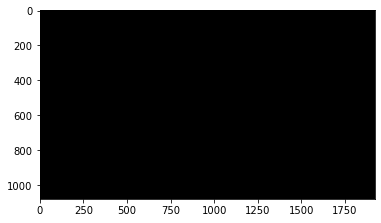

In [33]:
print_frame(vr[72].asnumpy())

In [22]:
gen = split_video3(VID_FILES[0])

In [23]:
clip = next(gen)

Compare frames every 1 seconds. This equals 29 frames.


KeyboardInterrupt: 

In [ ]:
clip.duration

In [17]:
start_time = time.time()
#mv_clips = build_mv_clips(clips, times)
mv_clips = build_mv_clips(times)
print('Time taken:', (time.time() - start_time)/60)

Media\Videos\The_Hunt_Disc_2_t00.mkv


DECORDError: [09:33:13] D:\a\decord\decord\src\video\video_reader.cc:167: CUDA not enabled. Requested context GPU(0).

In [22]:
music_video = concatenate_videoclips(mv_clips)

In [23]:
music_audio = AudioFileClip(FINAL_AUDIO).subclip(0, music_video.duration)

In [24]:
final_music_video = music_video.set_audio(music_audio)

In [25]:
i = 1
# Append unique id suffix to filename if file already exists
name = EXPORT_FILENAME.split('.')[0]
ext = EXPORT_FILENAME.split('.')[-1]
while os.path.exists(EXPORT_FILENAME):
    i += 1
    EXPORT_FILENAME = name + str(i) + '.' + ext

music_video23.mp4


In [26]:
final_music_video.write_videofile(export_name)

chunk:   0%|                                                                        | 0/5915 [00:00<?, ?it/s, now=None]

Moviepy - Building video music_video23.mp4.
MoviePy - Writing audio in music_video23TEMP_MPY_wvf_snd.mp3


t:   0%|                                                                    | 3/6432 [00:00<05:49, 18.42it/s, now=None]

MoviePy - Done.
Moviepy - Writing video music_video23.mp4



Moviepy - Done !
Moviepy - video ready music_video23.mp4
